In [95]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import resample
import librosa

In [11]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [12]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

In [13]:
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [21]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=32000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = resample(waveform, desired_length)
  return desired_sample_rate, waveform

In [71]:
wav_file_name = '../audio_files/train-horn-challenge.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
wav_data = wav_data[:, 0]
# sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
# wav_data = wav_data[:, 0]

In [73]:
# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

Sample rate: 44100 Hz
Total duration: 51.01s
Size of the input: 2249453


In [74]:
waveform = wav_data / tf.int16.max

In [101]:
# Listening to the wav file.
Audio(wav_data[92160:93696], rate=sample_rate)

In [96]:
splits = librosa.effects.split(waveform, top_db=15)

In [99]:
splits[0]

array([92160, 93696])

In [77]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [88]:
scores.shape

TensorShape([292, 521])

In [79]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Music


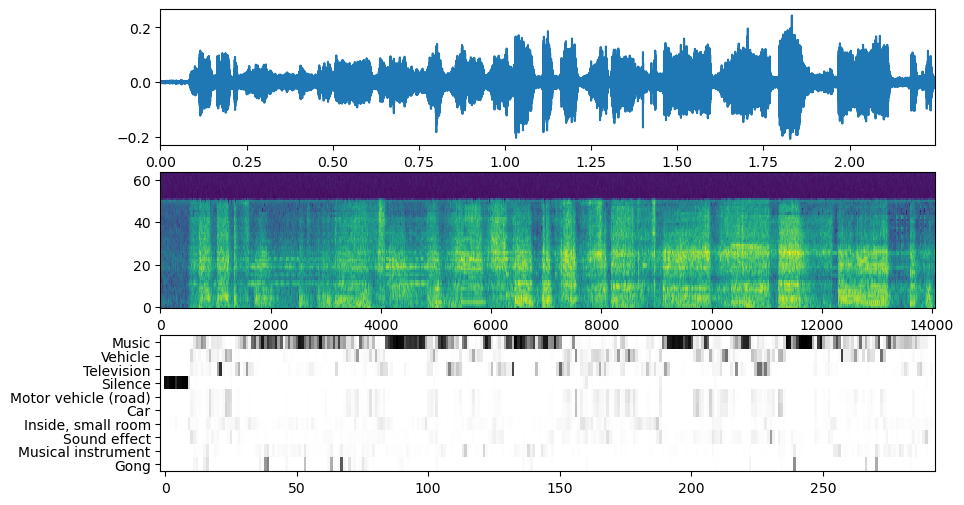

In [80]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [90]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [91]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

In [92]:
def read_wav(fname, output_sr, use_rosa=True):
    # small wrapper - i was seeing some slightly different 
    # results when loading with different libraries 
    if use_rosa:
        waveform, sr = librosa.load(fname, sr=output_sr)
    else:
        wav_data, sr = sf.read(fname, dtype=np.int16)
        
        if wav_data.ndim > 1: 
            # (ns, 2)
            wav_data = wav_data.mean(1)
        if sr != output_sr:
            wav_data = resampy.resample(wav_data, sr, output_sr)
        waveform = wav_data / 32768.0
    
    return waveform.astype(np.float64)

In [102]:
def remove_silence(waveform, top_db=15, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves


In [163]:
def remove_silence(waveform, top_db=15, min_chunk_size=10000, merge_chunks=False):
    # Loads sample into chunks of non-silence
    splits = librosa.effects.split(waveform, top_db=top_db)

    waves = []
    for start, end in splits:
        if (end - start) < min_chunk_size:
            continue
        waves.append([waveform[start:end]])
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                # out = np.concatenate((out, c))
                out.append(c)
        waves = out

    return waves

In [164]:
a = remove_silence(waveform)

In [165]:
len(a)

24

In [166]:
Audio(a[4], rate=sample_rate)